# Compare Manual to Automatic Meander Characterization

In this code we will compare the manual to the automatic detection


## Start Script
### Importing Packages

In [24]:
%load_ext autoreload
%autoreload 2
# %matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Importing Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from salem import GoogleVisibleMap, Map
import pyproj


# Importing pyMeander Packages
from WigglyRivers import RiverDatasets
from WigglyRivers import RiverFunctions as RF
from WigglyRivers import ExtractNHDPlusHRData as NHD
from WigglyRivers.utilities import utilities as utl
from WigglyRivers.utilities import filesManagement as FM
from WigglyRivers import Logger
from WigglyRivers import WaveletTreeFunctions as WTFunc
from WigglyRivers import CompareMeanders as CM

# Figure Settings
fs = 14
mpl.rcParams['font.size'] = fs
mpl.rcParams['font.family'] = 'Times New Roman'

In [26]:
def convert_str_float_list_vector(x_val):
    x_val = x_val.replace('[', '').replace(']', '').replace('\n', ',').replace(
        ' ', ',').split(',')
    x_val = np.array([float(x) for x in x_val if x != ''])
    return  x_val

In [27]:
# Start Logger
logger = Logger(console=True)

2024-02-06 21:40:50,740[INFO] set_logger: Starting log
2024-02-06 21:40:50,740[INFO] set_logger: Starting log


In [28]:
# Parameters
path_projects = './meander_comparison/characterization/manual_corrected/'
projects = utl.get_folders(path_projects)
path_projects_all = [f'{path_projects}{p}/' for p in projects]
path_projects_c = './meander_comparison/characterization/manual_with_automatic/'
path_projects_out = [f'{path_projects_c}{p}/' for p in projects]

print(projects)

# Current projection of information
projection = 'esri:102003'

['1404', '1206', '1208', '1002', '1402', '0601', '1113', '0808', '1108', '1305', '1017', '0904', '0107', '1021', '0106', '1030', '1202', '1006', '0510', '0714', '1009', '1406', '0803', '1110', '0406', '0408', '1701', '0412', '1307', '0701', '0708', '0307', '0104', '0504', '1211']


## Extract Data

In [29]:
# Open databases
bounds_array_str = 'extended'
# clip = '_clip_downstream'
clip = ''
data_link = {}
threshold = 0.75
for i_m, project in enumerate(projects):
    print(project)
    try:
        i_p = projects.index(project)
    except ValueError:
        raise ValueError(f'Project "{project}" not found')

    project_to_load = path_projects_out[i_p]
    # Load Meander database
    database = FM.load_data(
        f'{project_to_load}/meander_database_{bounds_array_str}{clip}.feather',
        pandas_dataframe=True)

    # Check common meanders between automatic and manual
    auto_df = database[database['automatic_flag'] == 1]
    manual_df = database[database['automatic_flag'] == 0]

    # Compare manual to automatic meanders
    database = CM.extract_closet_meanders(
        manual_df, auto_df, link_x='x', link_y='y', threshold=threshold)
    
    # Save database
    FM.save_data(database, path_output=f'{project_to_load}/',
                 file_name=f'compare_manual_auto_{bounds_array_str}{clip}.csv')
    
    if i_m == 0:
        database_all = database.copy()
    else:
        database_all = pd.concat([database_all, database], ignore_index=True)

FM.save_data(database_all, path_output=f'./meander_comparison/characterization/',
                file_name=f'compare_manual_auto_{bounds_array_str}_all{clip}.feather')



1404
1206
1208
1002
1402
0601
1113
0808
1108
1305
1017
0904
0107
1021
0106
1030
1202
1006
0510
0714
1009
1406
0803
1110
0406
0408
1701
0412
1307
0701
0708
0307
0104
0504
1211


In [195]:
# Functions
def plot_map(sub_set, i_m, ax, fontsize=12, scale=1, fs_ticks=12, **kwargs):
    # ----------------
    # Load API_KEY
    # ----------------
    import os
    import dotenv
    dotenv.load_dotenv()
    API_KEY = os.environ['API_KEY']
    wgs84 = pyproj.CRS("EPSG:4326")
    esri102003 = pyproj.CRS("esri:102003")
    transformer = pyproj.Transformer.from_crs(esri102003, wgs84)

    classification = ['I', 'II', 'III', 'IV']
    # ----------------
    # Extract Info
    # ----------------
    huc04_n = sub_set['huc04_n_1'].values[i_m]
    project = huc04_n.split('_')[0]
    try:
        i_p = projects.index(project)
    except ValueError:
        raise ValueError(f'Project "{project}" not found')
    project_to_load = path_projects_all[i_p]
    rivers = RiverDatasets()
    river_network_file = f'{project_to_load}/rivers_manual.hdf5'
    rivers.load_river_network(
        river_network_file,
        fn_meanders_database=f'{project_to_load}/meander_database_manual.feather')
    # The _2 is the automated detection
    x = rivers[huc04_n].x
    y = rivers[huc04_n].y
    x_m = sub_set['x_1'].values[i_m]
    y_m = sub_set['y_1'].values[i_m]
    x_a = sub_set['x_2'].values[i_m]
    y_a = sub_set['y_2'].values[i_m]
    f_oa = sub_set['f_oa'].values[i_m]
    f_om = sub_set['f_om'].values[i_m]
    zone = sub_set['Zone'].values[i_m]
    zone = classification[int(zone) - 1]
    so = sub_set['so_1'].values[i_m]
    # Projecting to WGS84
    lat, lon = transformer.transform(x, y)
    lat_m, lon_m = transformer.transform(x_m, y_m)
    lat_a, lon_a = transformer.transform(x_a, y_a)
    # Find overlapping points
    args = np.in1d(lat_m, lat_a)
    lat_o = lat_m[args]
    lon_o = lon_m[args]
    # ----------------
    # Create Plot
    # ----------------
    # Map Parameters
    # Map Extent
    lon_min = np.min([lon_m.min(), lon_a.min()])
    lon_max = np.max([lon_m.max(), lon_a.max()])
    lat_min = np.min([lat_m.min(), lat_a.min()])
    lat_max = np.max([lat_m.max(), lat_a.max()])
    # Create Map
    g = GoogleVisibleMap(x=[lon_min, lon_max],
        y=[lat_min, lat_max],
        scale=scale,  # scale is for more details
        maptype='satellite',
        key=API_KEY)

    ggl_img = g.get_vardata()
    ax.imshow(ggl_img)
    sm = Map(g.grid, factor=1, countries=False)
    sm.set_scale_bar(location=(0.88, 0.85), color='white', linewidth=1,
                    text_kwargs={'fontsize': fontsize - 2})
    sm.visualize(ax=ax) 
    x, y = sm.grid.transform(lon, lat)
    x_m, y_m = sm.grid.transform(lon_m, lat_m)
    x_a, y_a = sm.grid.transform(lon_a, lat_a)
    x_o, y_o = sm.grid.transform(lon_o, lat_o)
    ax.plot(x, y, '-b', label='River Centerline', **kwargs)
    ax.plot(x_a, y_a, '-r', label='Automated', **kwargs)
    ax.plot(x_m, y_m, 'o', color='g', label='Manual', **kwargs)
    ax.plot(x_o, y_o, 'o', color='gold', label='Overlap', **kwargs)
    ax.set_title(
        f'Zone {zone} (SO: {int(so)})\n($F_{{oa}}$: {f_oa:.2f} - $F_{{om}}$: {f_om:.2f})',
        fontsize=fontsize)
    # Rotate yticks 90 degrees
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90, va='center')
    # reduce fontsize of xticks
    ax.tick_params(axis='x', labelsize=fs_ticks)
    ax.tick_params(axis='y', labelsize=fs_ticks)
    # reduce size of xticks
    ax.set_xticks(ax.get_xticks()[::3])
    ax.set_yticks(ax.get_yticks()[::3])
    return ax, f_oa, f_om

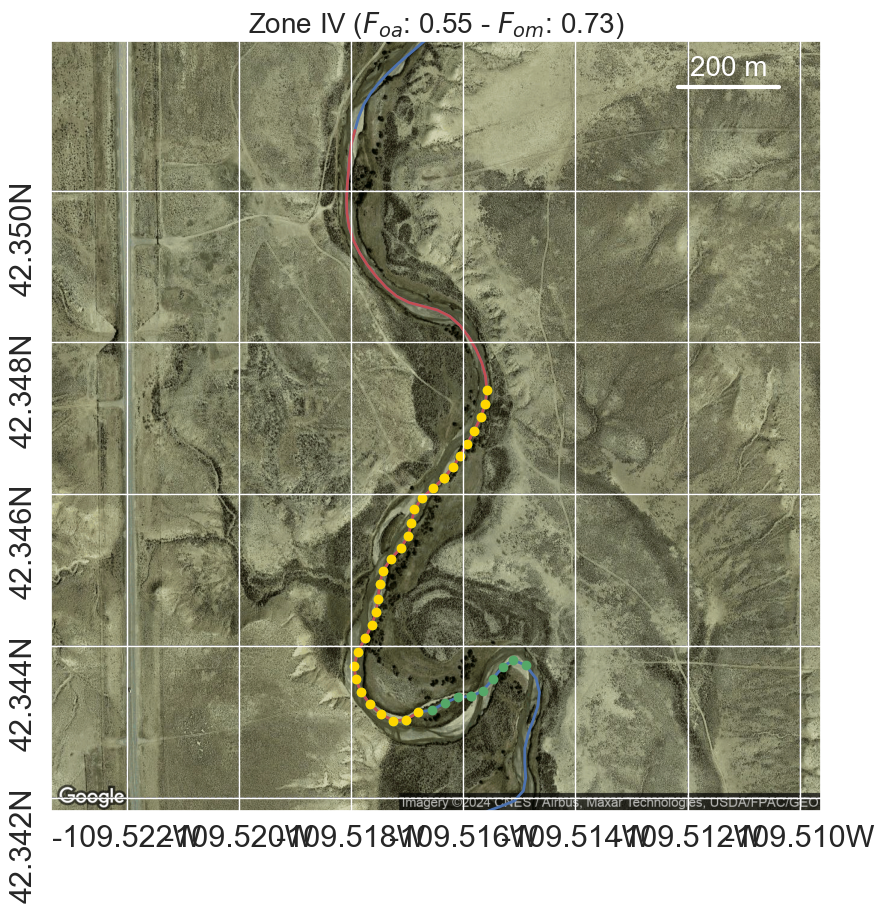

In [57]:
# Test creation of map for a meander
bounds_array_str = 'extended'
clip = ''
utl.cr_folder('../results/wavelet_analysis/comparison_meanders/')
data_link = FM.load_data('./meander_comparison/characterization/'
                         f'compare_manual_auto_{bounds_array_str}_all{clip}.feather',
                         pandas_dataframe=True)

sub_set = data_link[data_link['f_oa'] < 0.75]
sub_set = sub_set[sub_set['f_om'] < 0.75]

plt.close('all')
f, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_map(sub_set, i_m=1, ax=ax, fontsize=20, scale=2)
plt.show()


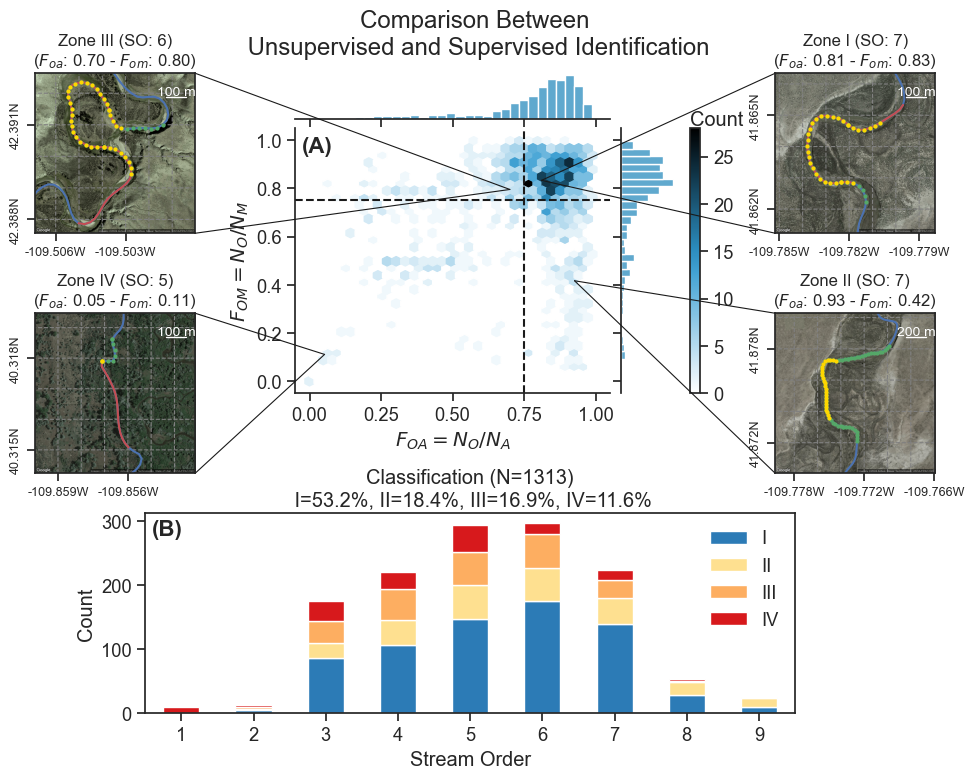

In [199]:
# Look comparison
plt.close('all')
fs = 8
mpl.rcParams['font.size'] = fs
mpl.rcParams['font.family'] = 'Times New Roman'
bounds_array_str = 'extended'
clip = ''
utl.cr_folder('../results/wavelet_analysis/comparison_meanders/')
data_link = FM.load_data('./meander_comparison/characterization/'
                         f'compare_manual_auto_{bounds_array_str}_all{clip}.feather',
                         pandas_dataframe=True)

classification = ['I', 'II', 'III', 'IV']
c_colors = ['r', 'g', 'b', 'y']

sns.set(font_scale=1.2, style="ticks", palette="deep")
# Plot hexbin
hexplot = sns.jointplot(data=data_link, x='f_oa', y='f_om', kind='hex',
              color='#2b8cbe',
              xlim=(-0.05, 1.05),
              ylim=(-0.05, 1.05), height=10)
hexplot.zorder = -1
plt.axhline(y=threshold, color='k', linestyle='--')
plt.axvline(x=threshold, color='k', linestyle='--')
plt.xlabel(r'$F_{OA}=N_O/N_A$')
plt.ylabel(r'$F_{OM}=N_O/N_M$')
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
fig = plt.gcf()
fig.subplots_adjust(bottom=0.5, top=0.9, left=0.32, right=0.70)

ax = plt.gca()
pos = ax.get_position()
cbar_ax = hexplot.fig.add_axes([pos.x1+0.08, pos.y0, .01, pos.height])
plt.colorbar(cax=cbar_ax)
fig.text(pos.x1+0.08, pos.y1+0.01, 'Count', va='center')

# Plot examples of meanders in the hexbin
# Zone I
ax_zone_1 = fig.add_axes([0.78, 0.7, 0.2, 0.2])
sub_set = data_link[data_link['f_oa'] > 0.75]
sub_set = sub_set[sub_set['f_om'] > 0.75]
_, f_oa, f_om = plot_map(
    sub_set, i_m=1, ax=ax_zone_1, fontsize=12, scale=2, fs_ticks=9,
    lw=1.5, markersize=2)
# Draw connection line between ax and ax_zone_1
con_max = mpl.patches.ConnectionPatch(
    xyB=(f_oa, f_om), xyA=(0, 1), coordsB='data', coordsA='axes fraction',
    axesB=ax, axesA=ax_zone_1, color='k', linestyle='-', linewidth=0.8)
con_min = mpl.patches.ConnectionPatch(
    xyB=(f_oa, f_om), xyA=(0, 0), coordsB='data', coordsA='axes fraction',
    axesB=ax, axesA=ax_zone_1, color='k', linestyle='-', linewidth=0.8)
ax_zone_1.add_artist(con_max)
ax_zone_1.add_artist(con_min)
# Zone II
ax_zone_1 = fig.add_axes([0.78, 0.4, 0.2, 0.2])
sub_set = data_link[data_link['f_oa'] > 0.75]
sub_set = sub_set[sub_set['f_om'] < 0.75]
_, f_oa, f_om = plot_map(
    sub_set, i_m=0, ax=ax_zone_1, fontsize=12, scale=2, fs_ticks=9,
    lw=1.5, markersize=2)
# Draw connection line between ax and ax_zone_1
con_max = mpl.patches.ConnectionPatch(
    xyB=(f_oa, f_om), xyA=(0, 1), coordsB='data', coordsA='axes fraction',
    axesB=ax, axesA=ax_zone_1, color='k', linestyle='-', linewidth=0.8)
con_min = mpl.patches.ConnectionPatch(
    xyB=(f_oa, f_om), xyA=(0, 0), coordsB='data', coordsA='axes fraction',
    axesB=ax, axesA=ax_zone_1, color='k', linestyle='-', linewidth=0.8)
ax_zone_1.add_artist(con_max)
ax_zone_1.add_artist(con_min)

# Zone III
ax_zone_1 = fig.add_axes([0.04, 0.7, 0.2, 0.2])
sub_set = data_link[data_link['f_oa'] < 0.75]
sub_set = sub_set[sub_set['f_om'] > 0.75]
_, f_oa, f_om = plot_map(
    sub_set, i_m=10, ax=ax_zone_1, fontsize=12, scale=2, fs_ticks=9,
    lw=1.5, markersize=2)
# Draw connection line between ax and ax_zone_1
con_max = mpl.patches.ConnectionPatch(
    xyB=(f_oa, f_om), xyA=(1, 1), coordsB='data', coordsA='axes fraction',
    axesB=ax, axesA=ax_zone_1, color='k', linestyle='-', linewidth=0.8)
con_min = mpl.patches.ConnectionPatch(
    xyB=(f_oa, f_om), xyA=(1, 0), coordsB='data', coordsA='axes fraction',
    axesB=ax, axesA=ax_zone_1, color='k', linestyle='-', linewidth=0.8)
ax_zone_1.add_artist(con_max)
ax_zone_1.add_artist(con_min)
# Zone IV
ax_zone_1 = fig.add_axes([0.04, 0.4, 0.2, 0.2])
sub_set = data_link[data_link['f_oa'] < 0.2]
sub_set = sub_set[sub_set['f_om'] < 0.2]
_, f_oa, f_om = plot_map(
    sub_set, i_m=0, ax=ax_zone_1, fontsize=12, scale=2, fs_ticks=9,
    lw=1.5, markersize=2)
# Draw connection line between ax and ax_zone_1
con_max = mpl.patches.ConnectionPatch(
    xyB=(f_oa, f_om), xyA=(1, 1), coordsB='data', coordsA='axes fraction',
    axesB=ax, axesA=ax_zone_1, color='k', linestyle='-', linewidth=0.8)
con_min = mpl.patches.ConnectionPatch(
    xyB=(f_oa, f_om), xyA=(1, 0), coordsB='data', coordsA='axes fraction',
    axesB=ax, axesA=ax_zone_1, color='k', linestyle='-', linewidth=0.8)
ax_zone_1.add_artist(con_max)
ax_zone_1.add_artist(con_min)

# Add histogram per Stream order
ax_hist = fig.add_axes([0.17, 0.1, 0.65, 0.25])
# Plot summary of the classification
data_plot = data_link.loc[:, ['so_1', 'Zone']]
zone_c = [classification[int(z) - 1] for z in data_plot['Zone']]
so_str = [f'{int(so)}' for so in data_plot['so_1']]
data_plot['Zone_c'] = zone_c
data_plot['so_1'] = so_str
dp_2 = data_plot.groupby(['Zone_c']).count()
dp = data_plot.pivot_table(values='Zone_c',
                           index=['so_1'], columns=['Zone_c'],
                           aggfunc=np.size)
colors = [
    '#2c7bb6',
    '#fee090',
    '#fdae61',
    '#d7191c',
]
total = len(data_plot)
title = (f'Classification (N={total})\n '
         f'I={dp_2.loc["I", "so_1"]/total*100:.1f}%, '
         f'II={dp_2.loc["II", "so_1"]/total*100:.1f}%, '
         f'III={dp_2.loc["III", "so_1"]/total*100:.1f}%, '
         f'IV={dp_2.loc["IV", "so_1"]/total*100:.1f}%')
dp.plot(kind='bar', stacked=True, figsize=(10, 8), color=colors,
        title=title, ax=ax_hist)
ax_hist.legend(title=None, frameon=False)
ax_hist.set_xlabel('Stream Order')
ax_hist.set_ylabel('Count')
ax_hist.set_xticklabels(ax_hist.get_xticklabels(), rotation=0)

# Add Regions of the plot
# ax.text(0.3, 0.85, 'III', color='gray', fontsize=20)
# Add Literals
ax.text(0.02, 0.97, '(A)', transform=ax.transAxes, fontsize=16,
        fontweight='bold', va='top')
ax_hist.text(0.01, 0.97, '(B)', transform=ax_hist.transAxes, fontsize=16,
             fontweight='bold', va='top')


# Add Title
plt.suptitle('Comparison Between\n Unsupervised and Supervised Identification')
# Save Figure
plt.savefig('../../manuscript_figures/Figure_12_meander_comparison.png',
            dpi=500)
plt.show()